In [207]:
# General info
# using Adam Optimization
# Shuffling sources every epoch
# SCHUSTER's MARMOUSI MODEL

# General parameters
GPU=4     # which GPU to use
plot=False # Plot Intermediate results
sigma=10.0   # Initial model smoothness  

# Inversion parameters
num_batches = 2
num_epochs = 5000

#gamma = 300  # Does not apply, Adam uses lr (learning rate) instead of gamma
# Adam learning rate
lr = 4

# Modeling parameters
freq = 15
dx = 10
dt = 0.001
nt = 4001
num_shots = 20
num_receivers_per_shot = 250
plot = True

# receiver_spacing = # computed below from ny,dx and num_receivers_per_shot

# Close the ouput.txt file with saved parameters


In [208]:
# Need to restart runtime before this step
import time
import torch
import numpy as np
import scipy.ndimage
import scipy.io
import matplotlib.pyplot as plt
import deepwave
import os
import csv
from sklearn.feature_extraction import image
from skimage.transform import resize

In [209]:
# Specify which GPU to use (in multi GPU machines)
torch.cuda.set_device(GPU)  #RB Necessary if device <> 0
GPU_string='cuda:'+str(GPU)
device = torch.device(GPU_string)

In [210]:
dz = 5.0 # 5m in each dimension
dt = 0.004 # 4ms
nz = 1000
ny = 40
nt = int(4 / dt) # 1s
peak_freq = 4
peak_source_time = 1/peak_freq


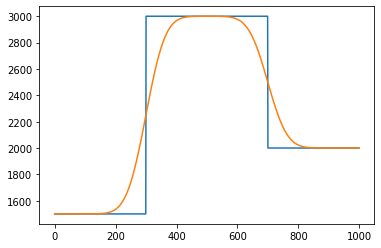

In [211]:
# constant 1500m/s model
import scipy
model_true = np.ones(nz) * 1500
np.shape(model)
model_true[300:] = 3000
model_true[700:] = 2000

model_init = scipy.ndimage.gaussian_filter1d(model_true,50)
plt.plot(model_true)
plt.plot(model_init)
model_true = torch.Tensor(model_true)
model_init = torch.Tensor(model_init)

In [212]:
num_dims = 1
num_sources_per_shot = 1
num_shots = 1
num_receivers_per_shot = 2

In [213]:
np.shape(model_true)

torch.Size([1000])

In [214]:
# one source and receiver at the same location
x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
x_r[0,1,0] = 200*dz
source_amplitudes = deepwave.wavelets.ricker(peak_freq, nt, dt,
                                             peak_source_time).reshape(-1, 1, 1)
source_amplitudes = source_amplitudes.to(device)
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dz)
receiver_amplitudes_true = prop(source_amplitudes, x_s.to(device), x_r.to(device), dt)



In [215]:
np.shape(receiver_amplitudes_true)

torch.Size([1000, 1, 2])

In [216]:
ram = receiver_amplitudes_true.cpu().numpy()

In [217]:
np.shape(ram)

(1000, 1, 2)

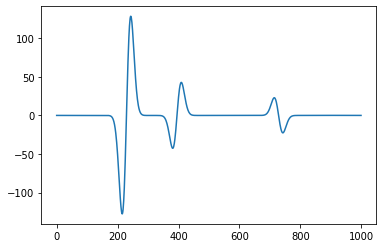

In [218]:
plt.plot(ram[:,0,1])

In [219]:
#model_init = torch.ones(nz) * 1500
model = model_init.clone()
model = model.to(device)
model.requires_grad = True

In [220]:
# To demonstrate chaining operations, during the inversion I will normalise the
# predicted receiver amplitudes so that each trace has a maximum value of 1.
# This will be compared (in the cost function) with the true data that has been
# similarly scaled. I apply that scaling to the true data now.
# This sort of scaling might be useful for real data where the absolute
# amplitudes are often not meaningful.
# I take the absolute value of the maximum and add a small positive value
# (1e-10) to ensure that the denominator is never zero
rcv_amps_true_max, _ = receiver_amplitudes_true.max(dim=0, keepdim=True)
rcv_amps_true_norm = receiver_amplitudes_true / (rcv_amps_true_max.abs() + 1e-10)

In [221]:
# Set-up inversion
# I use different learning rates for the model and source amplitude inversions
# as they have very different scales. An alternative would be to rescale the
# model.
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam([{'params': [model], 'lr': 10}])

Epoch: 0 Loss:  0.004819832742214203


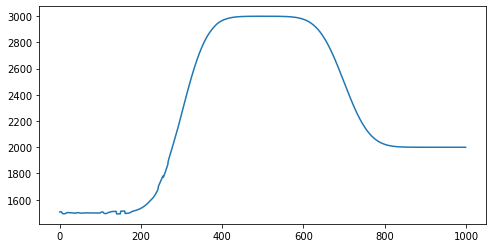

Epoch: 1 Loss:  0.0044334642589092255
Epoch: 2 Loss:  0.0040990496054291725
Epoch: 3 Loss:  0.0037360924761742353
Epoch: 4 Loss:  0.0034461633767932653
Epoch: 5 Loss:  0.0031489096581935883
Epoch: 6 Loss:  0.0028832086827605963
Epoch: 7 Loss:  0.00265836575999856
Epoch: 8 Loss:  0.0024409485049545765
Epoch: 9 Loss:  0.0022433516569435596
Epoch: 10 Loss:  0.0020793506409972906
Epoch: 11 Loss:  0.0019287082832306623
Epoch: 12 Loss:  0.0017872576136142015
Epoch: 13 Loss:  0.001669647521339357
Epoch: 14 Loss:  0.0015677271876484156
Epoch: 15 Loss:  0.0014693384291604161
Epoch: 16 Loss:  0.0013836940051987767
Epoch: 17 Loss:  0.0013111070729792118
Epoch: 18 Loss:  0.0012396727688610554
Epoch: 19 Loss:  0.0011729584075510502
Epoch: 20 Loss:  0.0011158696142956614
Epoch: 21 Loss:  0.0010604311246424913
Epoch: 22 Loss:  0.0010059168562293053
Epoch: 23 Loss:  0.0009579470497556031
Epoch: 24 Loss:  0.0009120364557020366
Epoch: 25 Loss:  0.0008657011785544455
Epoch: 26 Loss:  0.000823642825707793

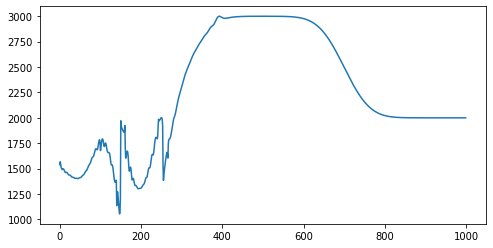

Epoch: 201 Loss:  8.850580343278125e-05
Epoch: 202 Loss:  8.822530799079686e-05
Epoch: 203 Loss:  8.80520383361727e-05
Epoch: 204 Loss:  8.781162614468485e-05
Epoch: 205 Loss:  8.77643542480655e-05
Epoch: 206 Loss:  8.761242497712374e-05
Epoch: 207 Loss:  8.74029501574114e-05
Epoch: 208 Loss:  8.734573202673346e-05
Epoch: 209 Loss:  8.723187784198672e-05
Epoch: 210 Loss:  8.725489897187799e-05
Epoch: 211 Loss:  8.698130113771185e-05
Epoch: 212 Loss:  8.689276000950485e-05
Epoch: 213 Loss:  8.669052476761863e-05
Epoch: 214 Loss:  8.655997226014733e-05
Epoch: 215 Loss:  8.628991054138169e-05
Epoch: 216 Loss:  8.63062814460136e-05
Epoch: 217 Loss:  8.616283594164997e-05
Epoch: 218 Loss:  8.605415496276692e-05
Epoch: 219 Loss:  8.598538261139765e-05
Epoch: 220 Loss:  8.586086914874613e-05
Epoch: 221 Loss:  8.560842252336442e-05
Epoch: 222 Loss:  8.568077464587986e-05
Epoch: 223 Loss:  8.541736315237358e-05
Epoch: 224 Loss:  8.537802204955369e-05
Epoch: 225 Loss:  8.520689880242571e-05
Epoc

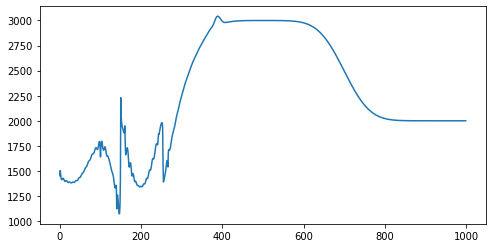

Epoch: 401 Loss:  6.88445070409216e-05
Epoch: 402 Loss:  6.869177741464227e-05
Epoch: 403 Loss:  6.869274511700496e-05
Epoch: 404 Loss:  6.859607674414292e-05
Epoch: 405 Loss:  6.845020106993616e-05
Epoch: 406 Loss:  6.832809594925493e-05
Epoch: 407 Loss:  6.829109770478681e-05
Epoch: 408 Loss:  6.830645725131035e-05
Epoch: 409 Loss:  6.809963815612718e-05
Epoch: 410 Loss:  6.808977195760235e-05
Epoch: 411 Loss:  6.799595576012507e-05
Epoch: 412 Loss:  6.794834916945547e-05
Epoch: 413 Loss:  6.78526921547018e-05
Epoch: 414 Loss:  6.775654037483037e-05
Epoch: 415 Loss:  6.769780884496868e-05
Epoch: 416 Loss:  6.761412805644795e-05
Epoch: 417 Loss:  6.746658618794754e-05
Epoch: 418 Loss:  6.73834583722055e-05
Epoch: 419 Loss:  6.739570380887017e-05
Epoch: 420 Loss:  6.727184518240392e-05
Epoch: 421 Loss:  6.723868864355609e-05
Epoch: 422 Loss:  6.707780994474888e-05
Epoch: 423 Loss:  6.702823156956583e-05
Epoch: 424 Loss:  6.69749133521691e-05
Epoch: 425 Loss:  6.682392995571718e-05
Epoc

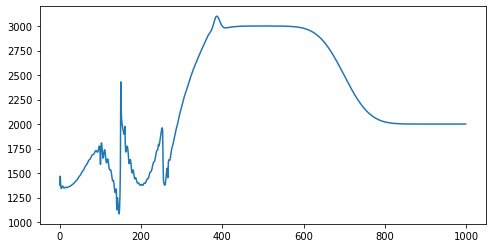

Epoch: 601 Loss:  5.515799784916453e-05
Epoch: 602 Loss:  5.519385013030842e-05
Epoch: 603 Loss:  5.51298689970281e-05
Epoch: 604 Loss:  5.50274780835025e-05
Epoch: 605 Loss:  5.489554314408451e-05
Epoch: 606 Loss:  5.499093822436407e-05
Epoch: 607 Loss:  5.485238943947479e-05
Epoch: 608 Loss:  5.472162592923269e-05
Epoch: 609 Loss:  5.486902955453843e-05
Epoch: 610 Loss:  5.470622272696346e-05
Epoch: 611 Loss:  5.4539370466955006e-05
Epoch: 612 Loss:  5.465056892717257e-05
Epoch: 613 Loss:  5.4513278882950544e-05
Epoch: 614 Loss:  5.451330071082339e-05
Epoch: 615 Loss:  5.4434920457424596e-05
Epoch: 616 Loss:  5.4333962907548994e-05
Epoch: 617 Loss:  5.4375741456169635e-05
Epoch: 618 Loss:  5.428799340734258e-05
Epoch: 619 Loss:  5.412029713625088e-05
Epoch: 620 Loss:  5.426500138128176e-05
Epoch: 621 Loss:  5.4120180720929056e-05
Epoch: 622 Loss:  5.405678166425787e-05
Epoch: 623 Loss:  5.398730718297884e-05
Epoch: 624 Loss:  5.399444853537716e-05
Epoch: 625 Loss:  5.38580134161748e-

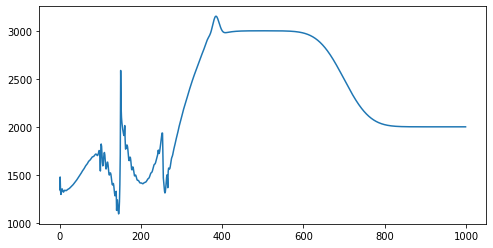

Epoch: 801 Loss:  4.5669847168028355e-05
Epoch: 802 Loss:  4.56806956208311e-05
Epoch: 803 Loss:  4.554901897790842e-05
Epoch: 804 Loss:  4.5479522668756545e-05
Epoch: 805 Loss:  4.5487191528081894e-05
Epoch: 806 Loss:  4.540950249065645e-05
Epoch: 807 Loss:  4.547846401692368e-05
Epoch: 808 Loss:  4.5322194637265056e-05
Epoch: 809 Loss:  4.539164001471363e-05
Epoch: 810 Loss:  4.5302997023100033e-05
Epoch: 811 Loss:  4.528123463387601e-05
Epoch: 812 Loss:  4.523780080489814e-05
Epoch: 813 Loss:  4.515753244049847e-05
Epoch: 814 Loss:  4.522430390352383e-05
Epoch: 815 Loss:  4.5097898691892624e-05
Epoch: 816 Loss:  4.512744635576382e-05
Epoch: 817 Loss:  4.5054577640257776e-05
Epoch: 818 Loss:  4.495964458328672e-05
Epoch: 819 Loss:  4.499147325986996e-05
Epoch: 820 Loss:  4.486920443014242e-05
Epoch: 821 Loss:  4.4781179894926026e-05
Epoch: 822 Loss:  4.479154449654743e-05
Epoch: 823 Loss:  4.473151784623042e-05
Epoch: 824 Loss:  4.469610212254338e-05
Epoch: 825 Loss:  4.4680342398351

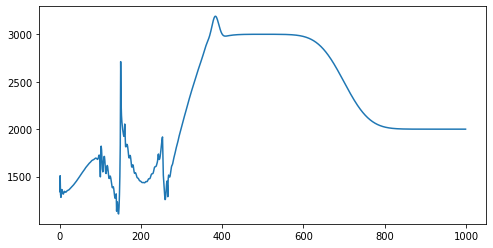

Epoch: 1001 Loss:  3.8597914681304246e-05
Epoch: 1002 Loss:  3.8476620829897e-05
Epoch: 1003 Loss:  3.8387450331356376e-05
Epoch: 1004 Loss:  3.8373516872525215e-05
Epoch: 1005 Loss:  3.837451367871836e-05
Epoch: 1006 Loss:  3.832985748886131e-05
Epoch: 1007 Loss:  3.827588079730049e-05
Epoch: 1008 Loss:  3.8205133023438975e-05
Epoch: 1009 Loss:  3.8165915611898527e-05
Epoch: 1010 Loss:  3.8184669392649084e-05
Epoch: 1011 Loss:  3.818038749159314e-05
Epoch: 1012 Loss:  3.819931953330524e-05
Epoch: 1013 Loss:  3.813159855781123e-05
Epoch: 1014 Loss:  3.813841613009572e-05
Epoch: 1015 Loss:  3.804695006692782e-05
Epoch: 1016 Loss:  3.8035133911762387e-05
Epoch: 1017 Loss:  3.794282747549005e-05
Epoch: 1018 Loss:  3.791318158619106e-05
Epoch: 1019 Loss:  3.790402479353361e-05
Epoch: 1020 Loss:  3.7819805584149435e-05
Epoch: 1021 Loss:  3.78341501345858e-05
Epoch: 1022 Loss:  3.791601920966059e-05
Epoch: 1023 Loss:  3.770899274968542e-05
Epoch: 1024 Loss:  3.7736095691798255e-05
Epoch: 102

Epoch: 1200 Loss:  3.2981984986690804e-05


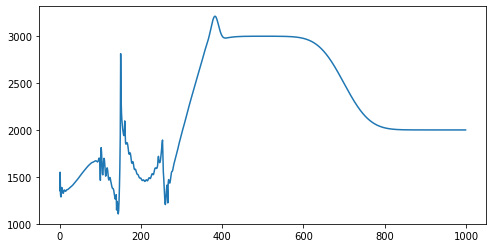

Epoch: 1201 Loss:  3.2828687835717574e-05
Epoch: 1202 Loss:  3.301008837297559e-05
Epoch: 1203 Loss:  3.2972191547742113e-05
Epoch: 1204 Loss:  3.287820072728209e-05
Epoch: 1205 Loss:  3.296776412753388e-05
Epoch: 1206 Loss:  3.303270204924047e-05
Epoch: 1207 Loss:  3.304492202005349e-05
Epoch: 1208 Loss:  3.2902062230277807e-05
Epoch: 1209 Loss:  3.300849857623689e-05
Epoch: 1210 Loss:  3.2945143175311387e-05
Epoch: 1211 Loss:  3.291837128927e-05
Epoch: 1212 Loss:  3.2953474146779627e-05
Epoch: 1213 Loss:  3.266959902248345e-05
Epoch: 1214 Loss:  3.281944736954756e-05
Epoch: 1215 Loss:  3.2706961064832285e-05
Epoch: 1216 Loss:  3.252622263971716e-05
Epoch: 1217 Loss:  3.250725785619579e-05
Epoch: 1218 Loss:  3.2433563319500536e-05
Epoch: 1219 Loss:  3.239875877625309e-05
Epoch: 1220 Loss:  3.2378651667386293e-05
Epoch: 1221 Loss:  3.2293199183186516e-05
Epoch: 1222 Loss:  3.2406183890998363e-05
Epoch: 1223 Loss:  3.243704486521892e-05
Epoch: 1224 Loss:  3.234677933505736e-05
Epoch: 12

Epoch: 1399 Loss:  2.8550130082294345e-05
Epoch: 1400 Loss:  2.860408858396113e-05


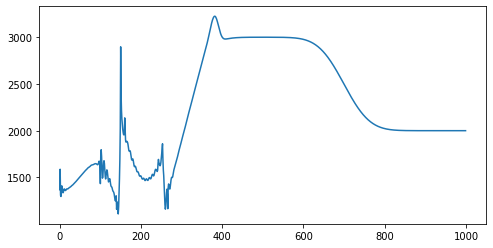

Epoch: 1401 Loss:  2.858777043002192e-05
Epoch: 1402 Loss:  2.846758252417203e-05
Epoch: 1403 Loss:  2.847578434739262e-05
Epoch: 1404 Loss:  2.836256317095831e-05
Epoch: 1405 Loss:  2.843114998540841e-05
Epoch: 1406 Loss:  2.8448479497455992e-05
Epoch: 1407 Loss:  2.8384187316987664e-05
Epoch: 1408 Loss:  2.8337033654679544e-05
Epoch: 1409 Loss:  2.842191679519601e-05
Epoch: 1410 Loss:  2.8373899112921208e-05
Epoch: 1411 Loss:  2.8250098694115877e-05
Epoch: 1412 Loss:  2.829627010214608e-05
Epoch: 1413 Loss:  2.8351028959150426e-05
Epoch: 1414 Loss:  2.8312424547038972e-05
Epoch: 1415 Loss:  2.837305873981677e-05
Epoch: 1416 Loss:  2.8248978196643293e-05
Epoch: 1417 Loss:  2.8136470064055175e-05
Epoch: 1418 Loss:  2.82024539046688e-05
Epoch: 1419 Loss:  2.8083262805012055e-05
Epoch: 1420 Loss:  2.8044798455084674e-05
Epoch: 1421 Loss:  2.8060245313099585e-05
Epoch: 1422 Loss:  2.8040556571795605e-05
Epoch: 1423 Loss:  2.8051217668689787e-05
Epoch: 1424 Loss:  2.8000406018691137e-05
Ep

Epoch: 1598 Loss:  2.51981782639632e-05
Epoch: 1599 Loss:  2.5114875825238414e-05
Epoch: 1600 Loss:  2.5032119083334692e-05


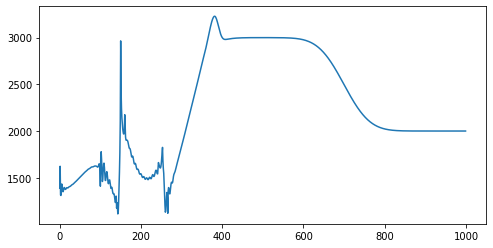

Epoch: 1601 Loss:  2.524807132431306e-05
Epoch: 1602 Loss:  2.5149000066448934e-05
Epoch: 1603 Loss:  2.5085801098612137e-05
Epoch: 1604 Loss:  2.5093957447097637e-05
Epoch: 1605 Loss:  2.50201192102395e-05
Epoch: 1606 Loss:  2.498837602615822e-05
Epoch: 1607 Loss:  2.5012654077727348e-05
Epoch: 1608 Loss:  2.500785376469139e-05
Epoch: 1609 Loss:  2.4953520551207475e-05
Epoch: 1610 Loss:  2.5032555640791543e-05
Epoch: 1611 Loss:  2.4990564270410687e-05
Epoch: 1612 Loss:  2.4867285901564173e-05
Epoch: 1613 Loss:  2.4932411179179326e-05
Epoch: 1614 Loss:  2.4858762117219158e-05
Epoch: 1615 Loss:  2.5013236154336482e-05
Epoch: 1616 Loss:  2.482674244674854e-05
Epoch: 1617 Loss:  2.4892968212952837e-05
Epoch: 1618 Loss:  2.4799319362500682e-05
Epoch: 1619 Loss:  2.497322748240549e-05
Epoch: 1620 Loss:  2.4900862626964226e-05
Epoch: 1621 Loss:  2.478054739185609e-05
Epoch: 1622 Loss:  2.4872020730981603e-05
Epoch: 1623 Loss:  2.4781649699434638e-05
Epoch: 1624 Loss:  2.4719869543332607e-05


Epoch: 1799 Loss:  2.2891730623086914e-05
Epoch: 1800 Loss:  2.2774411263526417e-05


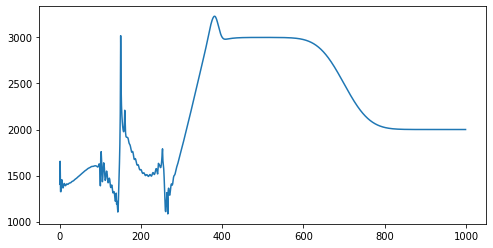

Epoch: 1801 Loss:  2.2705660740029998e-05
Epoch: 1802 Loss:  2.2540014469996095e-05
Epoch: 1803 Loss:  2.245923133159522e-05
Epoch: 1804 Loss:  2.23920196731342e-05
Epoch: 1805 Loss:  2.2447742594522424e-05
Epoch: 1806 Loss:  2.2423620976042002e-05
Epoch: 1807 Loss:  2.255778781545814e-05
Epoch: 1808 Loss:  2.2427542717196047e-05
Epoch: 1809 Loss:  2.251137630082667e-05
Epoch: 1810 Loss:  2.2636861103819683e-05
Epoch: 1811 Loss:  2.2428304873756133e-05
Epoch: 1812 Loss:  2.2433050617109984e-05
Epoch: 1813 Loss:  2.235860301880166e-05
Epoch: 1814 Loss:  2.2424539565690793e-05
Epoch: 1815 Loss:  2.2259680918068625e-05
Epoch: 1816 Loss:  2.2243486455408856e-05
Epoch: 1817 Loss:  2.2329271814669482e-05
Epoch: 1818 Loss:  2.230997233709786e-05
Epoch: 1819 Loss:  2.2313657609629445e-05
Epoch: 1820 Loss:  2.2209531380212866e-05
Epoch: 1821 Loss:  2.222332295787055e-05
Epoch: 1822 Loss:  2.225418938905932e-05
Epoch: 1823 Loss:  2.2193078621057793e-05
Epoch: 1824 Loss:  2.2131023797555827e-05
E

Epoch: 1998 Loss:  2.033089731412474e-05
Epoch: 1999 Loss:  2.0455803678487428e-05
Runtime: 205.23227977752686


In [222]:
# Iterative inversion loop
t_start = time.time()
num_batches = 1 # split data into 10 batches for speed and reduced memory use
num_shots_per_batch = int(num_shots / num_batches)
num_epochs = 2000# Pass through the entire dataset 30 times
vmin, vmax = np.percentile(model_true.numpy(), [2,98]) # For plotting
for epoch in range(num_epochs):
  epoch_loss = 0.0
  for it in range(num_batches):
    optimizer.zero_grad()
    prop = deepwave.scalar.Propagator({'vp': model}, dx)
    batch_src_amps = source_amplitudes.repeat(1, num_shots_per_batch, 1)
    batch_rcv_amps_true = rcv_amps_true_norm[:,it::num_batches].to(device)
    batch_x_s = x_s[it::num_batches].to(device)
    batch_x_r = x_r[it::num_batches].to(device)
    batch_rcv_amps_pred = prop(batch_src_amps, batch_x_s, batch_x_r, dt)
    batch_rcv_amps_pred_max, _ = batch_rcv_amps_pred.max(dim=0, keepdim=True)
    # Normalize amplitudes by dividing by the maximum amplitude of each receiver
    batch_rcv_amps_pred_norm = batch_rcv_amps_pred / (batch_rcv_amps_pred_max.abs() + 1e-10)
    loss = criterion(batch_rcv_amps_pred_norm, batch_rcv_amps_true)
    epoch_loss += loss.item()
    loss.backward()
    optimizer.step()
  print('Epoch:', epoch, 'Loss: ', epoch_loss)
  if epoch % 200 == 0:
    plt.figure(figsize=(8, 4))
    plt.plot(model.cpu().detach().numpy())
    plt.show()
t_end = time.time()
print('Runtime:', t_end - t_start)